In [1]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision.transforms.functional import crop
import torch
import torchvision.transforms as transforms
import gc
from torch.utils.data import DataLoader,Dataset


/home/ggausachs/DadesUAB/Data
['231218151009', '231218171115', '231218184644', '231219111259', '231219121247', '231219125929', '231219160955', '231219163825', '231221152928', '231221160009', '231221173600', '231222090337', '240112122326', '240117120951', '240130104100', '240130110959', '240201120017', '240207155139', '240212155248', '240301122444', '240403123945']
/home/ggausachs/DadesUAB/Data/231218151009/Decubit Supi_Neutre_Llençol_IR.png
/home/ggausachs/DadesUAB/Data/231218151009/Decubit Supi_Neutre_Llençol_Pressio.csv


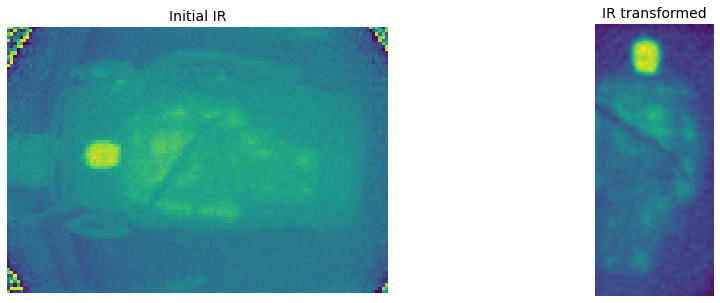

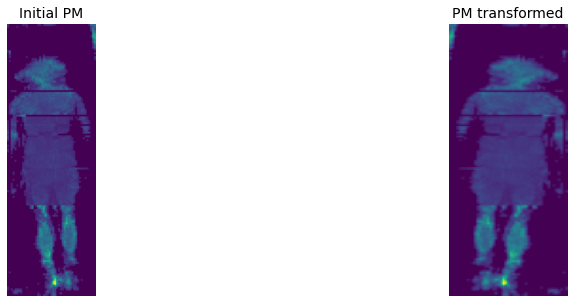

/home/ggausachs/DadesUAB/Data/231218151009/Decubit Supi_Neutre_Manta_IR.png
/home/ggausachs/DadesUAB/Data/231218151009/Decubit Supi_Neutre_Manta_Pressio.csv


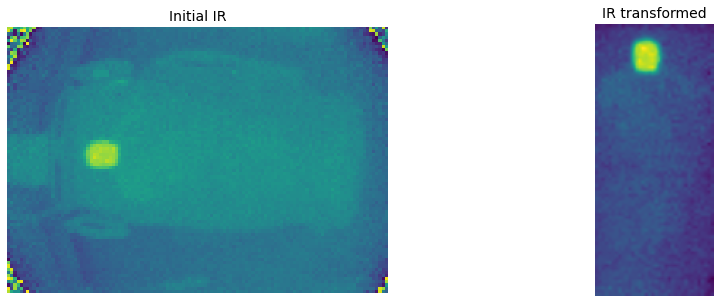

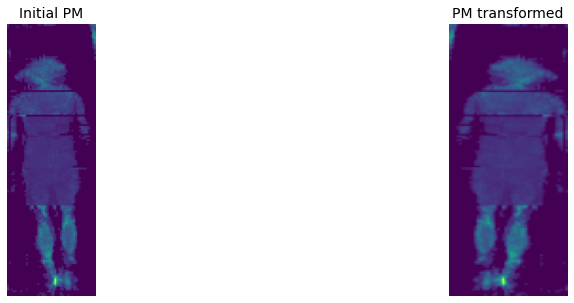

/home/ggausachs/DadesUAB/Data/231218151009/Decubit Supi_Neutre_Roba_IR.png
/home/ggausachs/DadesUAB/Data/231218151009/Decubit Supi_Neutre_Roba_Pressio.csv


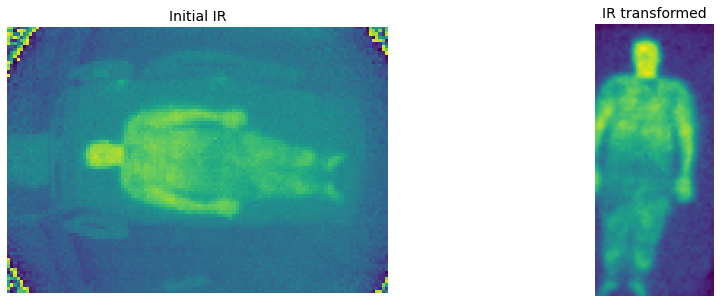

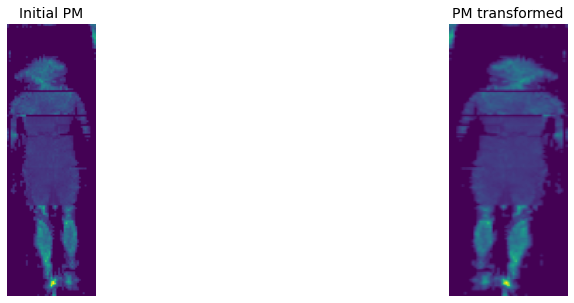

In [ ]:
def to_float32_and_scale(tensor,global_min,global_max):
    tensor = tensor.float()
    tensor = (tensor - global_min) / (global_max - global_min)
    return tensor

def crop_array(array):
    
    return crop(array, 20, 28, 85, 36)

path_data = os.path.join(os.path.dirname(os.path.dirname((os.getcwd()))),'DadesUAB/Data')

print(path_data)
    
transform = {
            'input': transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(crop_array),
                transforms.Resize((192, 84))]),
            'output': transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                transforms.Lambda(lambda x: to_float32_and_scale(x,0,905)),
                transforms.Resize((192, 84))])
}

max_ir = -np.inf
min_ir = np.inf
max_pm = -np.inf
min_pm = np.inf
images_tensor = {}
images_tensor['input']=[]
images_tensor['output']=[]
folders = os.listdir(path_data)
folders_sorted = sorted(folders)
print(folders_sorted)
for folder in folders_sorted[:1]:
    directory = os.path.join(path_data,folder)
    #print(directory)
    pattern = os.path.join(directory, '*IR.png')
    files_ir = glob(pattern)
    files_ir = sorted(files_ir)
    #print(len(files_ir))
    #print(files_ir)
    pattern = os.path.join(directory, '*Pressio.csv')
    files_pm = glob(pattern)
    files_pm = sorted(files_pm)
    #print(len(files_pm))
    #print(files_pm)

    for ir,pm in zip(files_ir,files_pm):
        print(ir)
        print(pm)
        ir_array = mpimg.imread(ir)
        array = np.rot90(ir_array, k=1, axes=(1,0))
        array_2 = np.copy(array)
        tensor_final = transform['input'](array_2)
        images_tensor['input'].append(tensor_final)
        ir_array_final = tensor_final.squeeze().numpy()
        pm = pd.read_csv(pm)
        pm_array = pm.to_numpy()
        pm_array = np.rot90(pm_array, k=1, axes=(1,0))
        pm_array_2 = np.copy(pm_array)
        pm_tensor = transform['output'](pm_array_2)
        images_tensor['output'].append(pm_tensor)
        final_array = pm_tensor.squeeze().numpy()
        
        pmin, pmax = final_array.min(), final_array.max()
        min_pm = min(min_pm, pmin)
        max_pm = max(max_pm, pmax)
            
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
        axes[0].imshow(ir_array)
        axes[0].set_title("Initial IR", fontsize=14)
        axes[0].axis('off')
                
        axes[1].imshow(ir_array_final)
        axes[1].set_title("IR transformed",fontsize=14)
        axes[1].axis('off')

            #plt.savefig('IRUAB.png')
                
            #axes[2].imshow(final_array)
            #axes[2].axis('off')
        plt.show()
            
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
        axes[0].imshow(pm_array)
        axes[0].set_title("Initial PM", fontsize=14)
        axes[0].axis('off')
                
        axes[1].imshow(final_array)
        axes[1].set_title("PM transformed",fontsize=14)
        axes[1].axis('off')

            #plt.savefig('PMUAB.png')
                
            #axes[2].imshow(final_array)
            #axes[2].axis('off')
        plt.show()
                
print(max_pm,min_pm)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data_dict):
        self.inputs = data_dict['input']
        self.outputs = data_dict['output']
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_tensor = self.inputs[idx]
        output_tensor = self.outputs[idx]
        return input_tensor,output_tensor

Model Loaded
UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), str

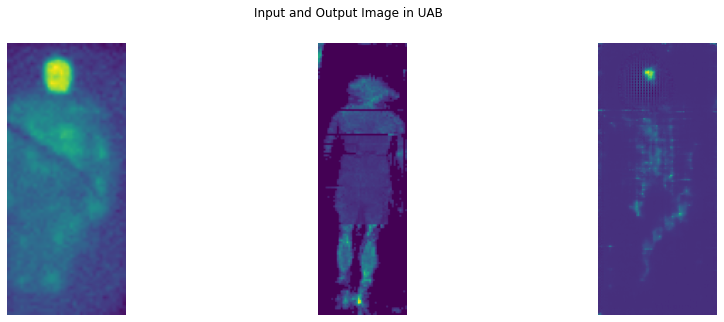

output: 0.12562919 -0.018509395
target: 0.47403315 0.0


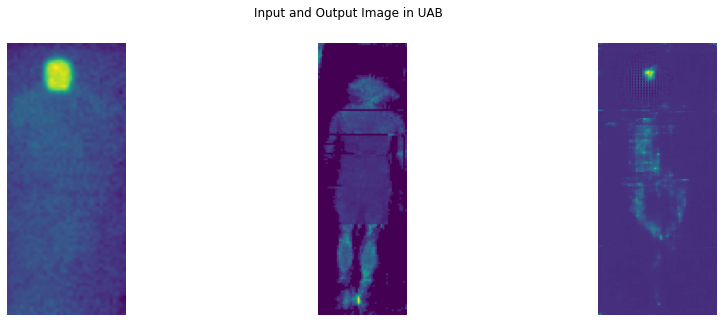

output: 0.1267426 -0.021765955
target: 0.40552485 0.0


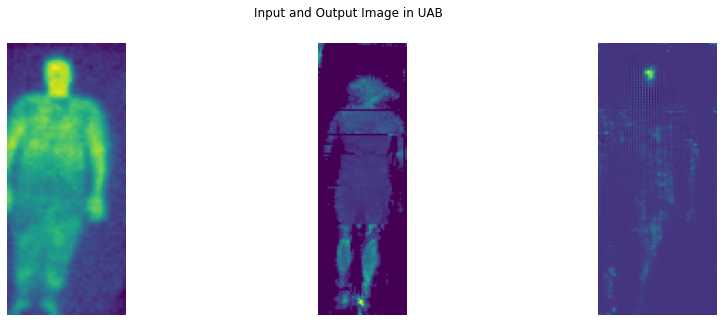

output: 0.13270497 -0.022661455
target: 0.3116022 0.0


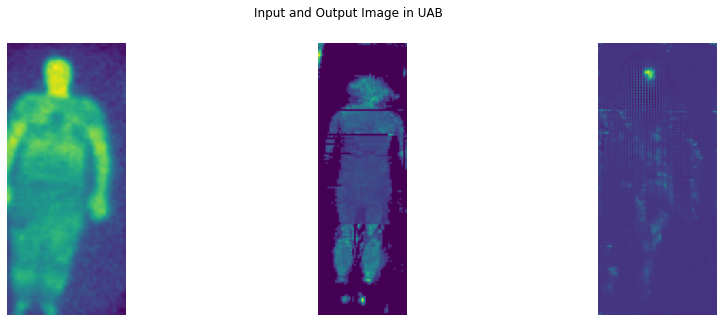

output: 0.09971925 -0.020226248
target: 0.3314917 0.0


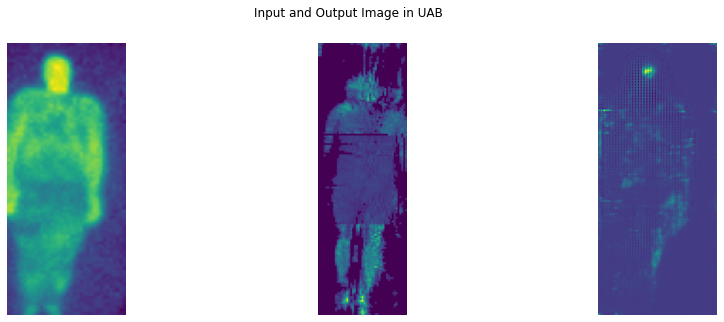

output: 0.13503909 -0.015483566
target: 0.32596686 0.0


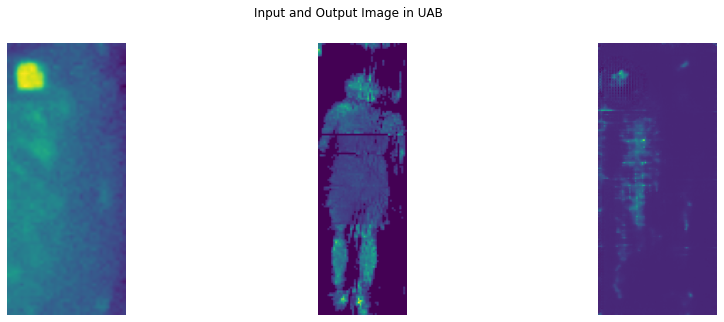

output: 0.09981417 -0.00969363
target: 0.32928178 0.0


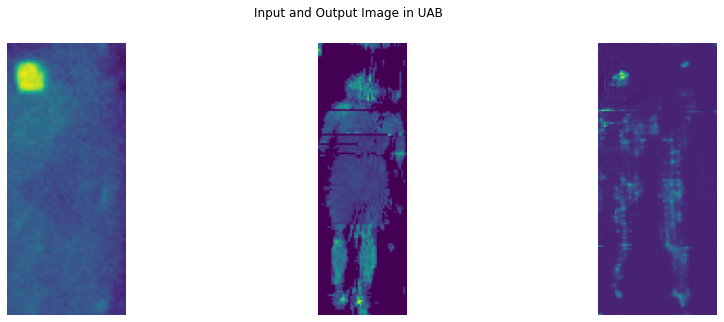

output: 0.07379003 -0.016330726
target: 0.2961326 0.0


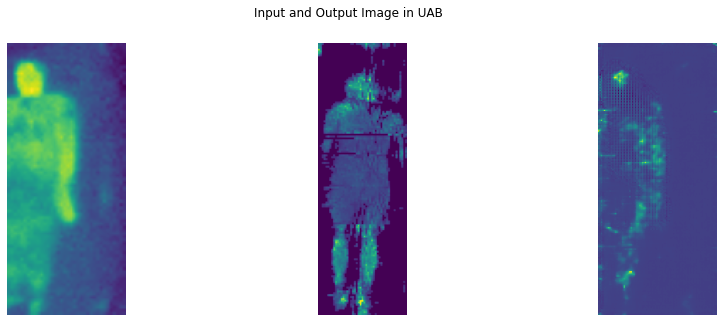

output: 0.10747642 -0.018276699
target: 0.3569061 0.0


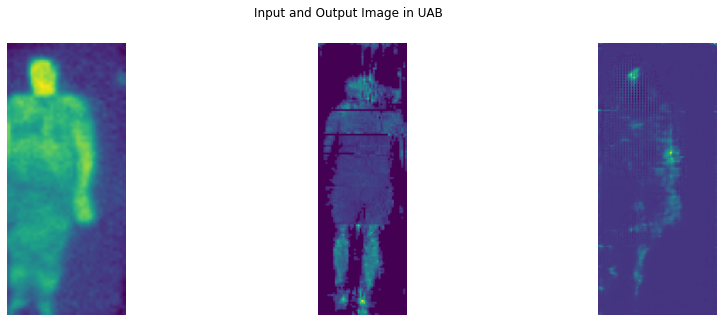

output: 0.13943839 -0.018461235
target: 0.29060772 0.0


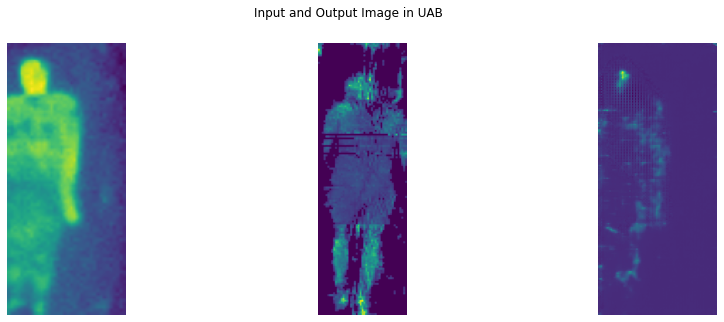

output: 0.122880936 -0.014417656
target: 0.5922652 0.0


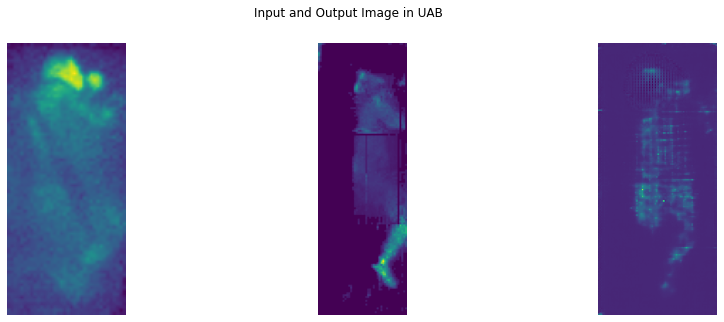

output: 0.07852478 -0.007070072
target: 0.56574583 0.0


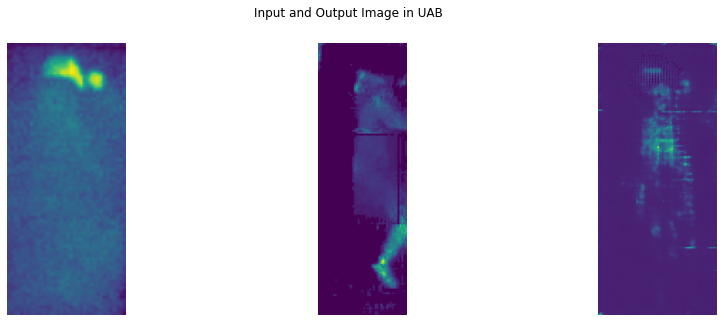

output: 0.08062941 -0.018720157
target: 0.5248619 0.0


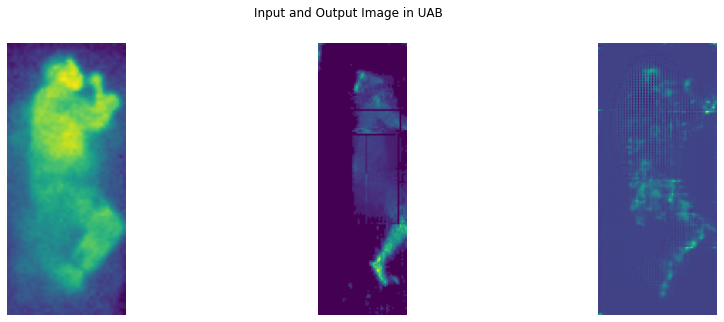

output: 0.1212213 -0.008178957
target: 0.55801105 0.0


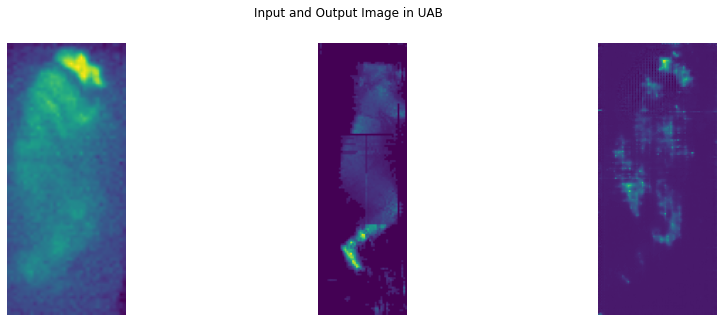

output: 0.11262863 -0.010003932
target: 0.53370166 0.0


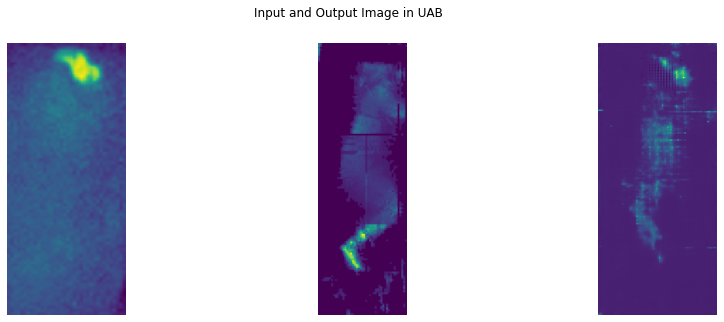

output: 0.12524614 -0.017936714
target: 0.5900552 0.0


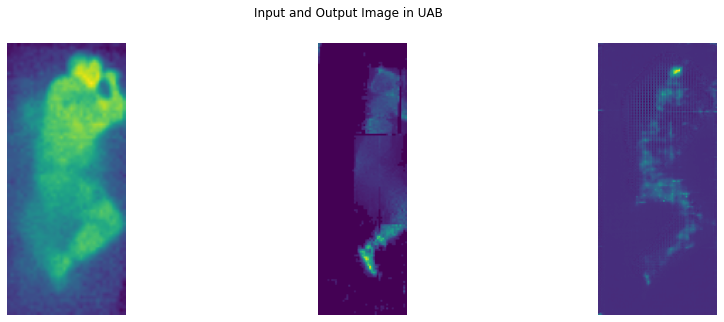

output: 0.082163475 -0.020474203
target: 0.57348067 0.0


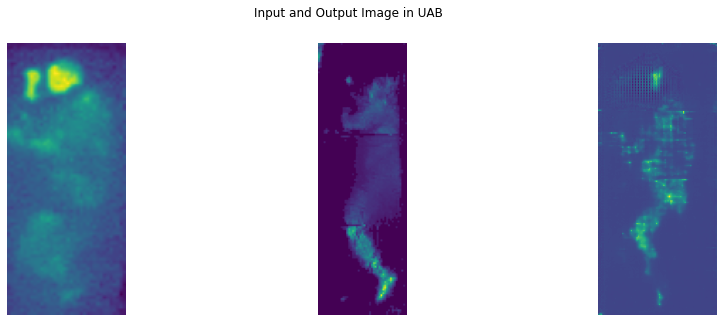

output: 0.08312018 -0.014398821
target: 0.59116024 0.0


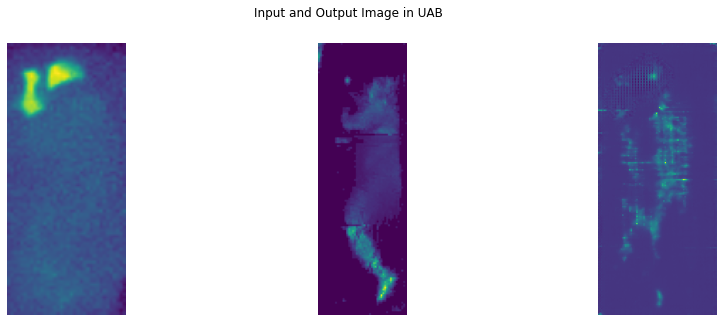

output: 0.13553463 -0.023035295
target: 0.6254144 0.0


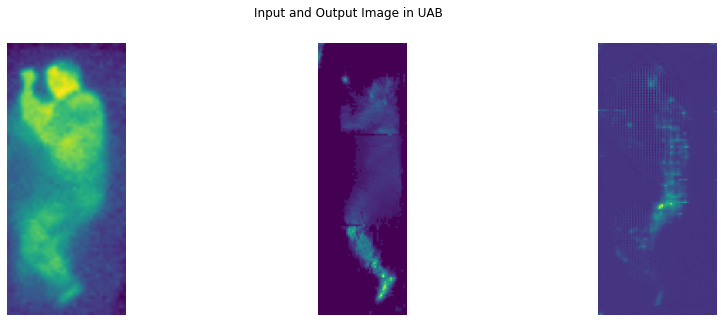

output: 0.09801697 -0.017415293
target: 0.59337014 0.0


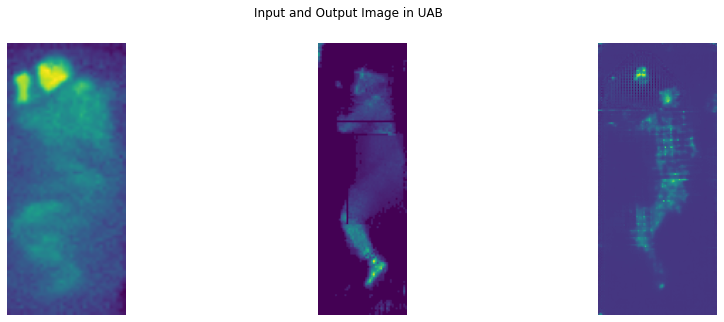

output: 0.098243944 -0.012895353
target: 0.5171271 0.0


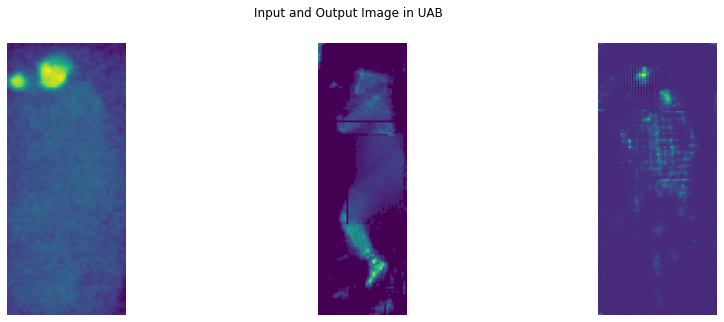

output: 0.09846487 -0.018956669
target: 0.6232044 0.0


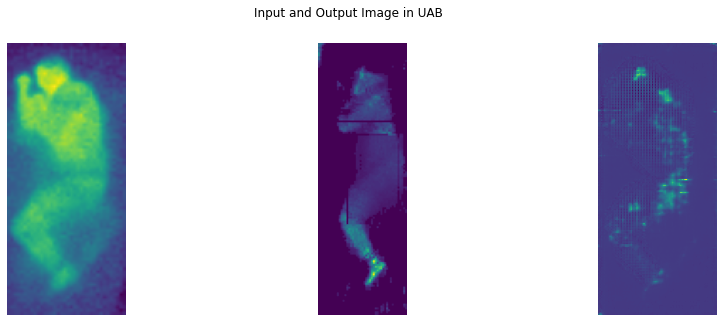

output: 0.1155274 -0.011215456
target: 0.3082873 0.0


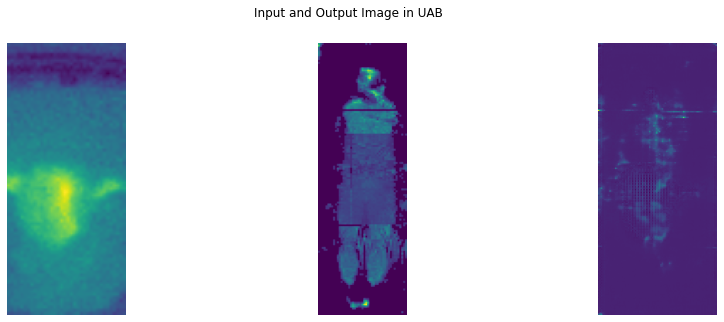

output: 0.112407476 -0.0123020485
target: 0.3071823 0.0


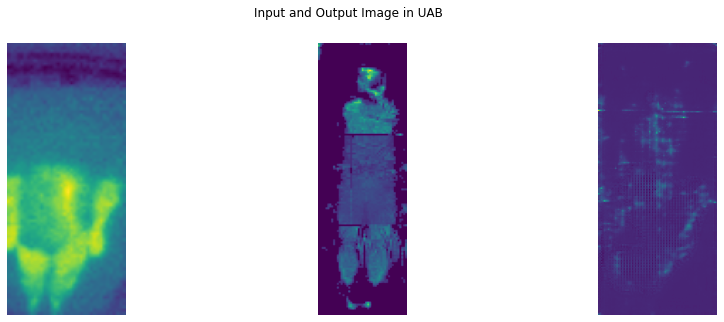

output: 0.057068236 -0.012173064
target: 0.4839779 0.0


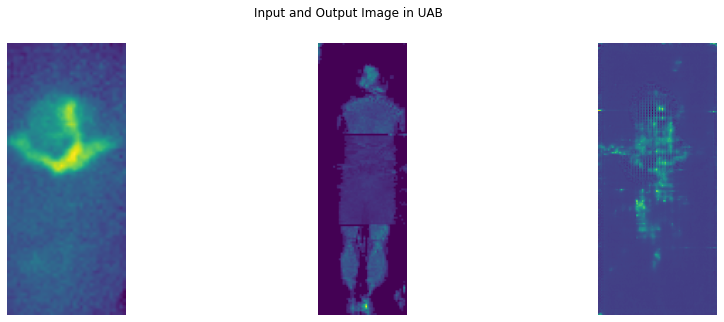

output: 0.10148676 -0.014915474
target: 0.3966851 0.0


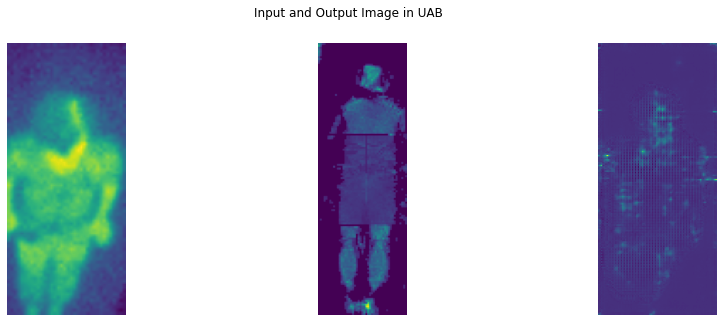

output: 0.077737026 -0.020845897
target: 0.319337 0.0


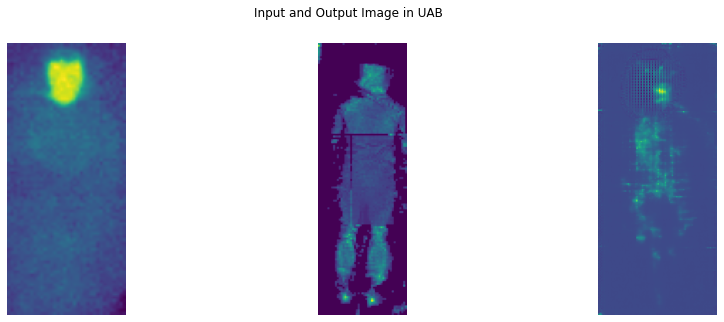

output: 0.091427475 -0.020763405
target: 0.30607736 0.0


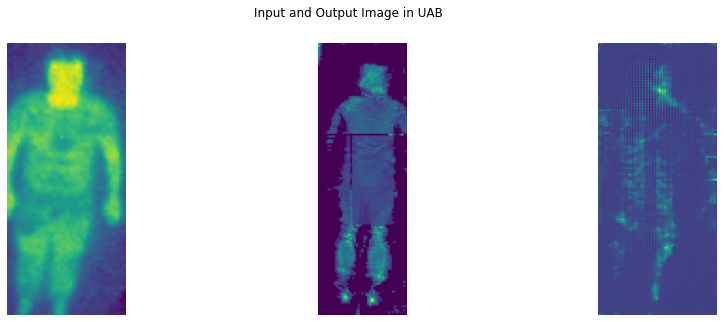

output: 0.06868176 -0.021539457
target: 0.48618785 0.0


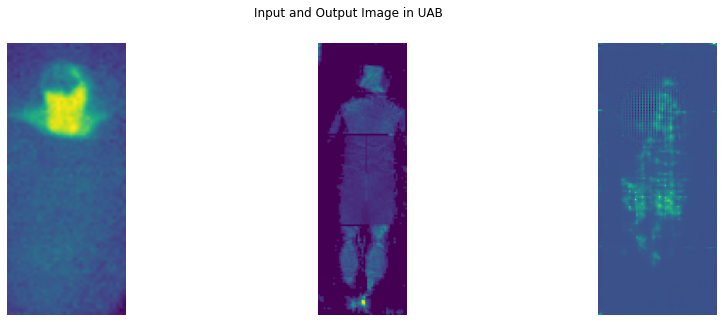

output: 0.07962854 -0.023091324
target: 0.49834254 0.0


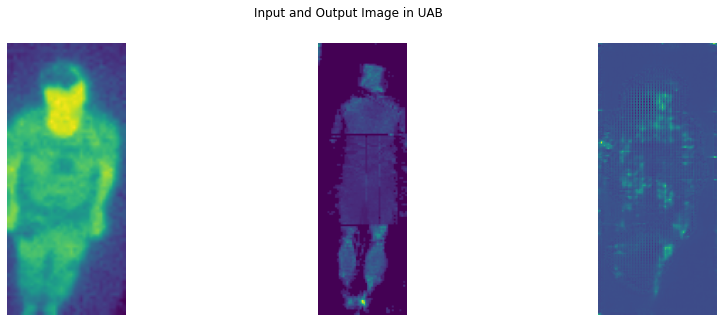

In [63]:
from Models import (
    UNet,
    UNet_phy
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "UNet"
name_model = "AAA - MSELoss - 512_20240529200423.pth"

models = {"UNet": UNet.UNET, "UNet_phy": UNet_phy.UNET_phy}

features = [64,128,256,512]

model = models[MODEL_NAME](1, 1,features).to(DEVICE)

# Load the model
model_file = os.path.join(os.path.join((os.getcwd()),'Models/SavedModels'),name_model)

try:
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    model.to(DEVICE)
except Exception as e:
    raise RuntimeError(f"An error occurred while reading the file: {e}")
else:
    print('Model Loaded')

print(model)

model.eval()
torch.cuda.empty_cache()  # Clean CUDA Cache if used GPU
gc.collect()  # Collect trash to free memory not used


custom_dataset = CustomDataset(images_tensor)

test_loader = DataLoader(custom_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)

for input_images,target in test_loader:
    input_img = input_images.to(DEVICE)
    output_img = model(input_img)
    input_images = input_img.squeeze().cpu().numpy()
    output_images = output_img.squeeze().detach().cpu().numpy()
    target_img = target.squeeze().cpu().numpy()

    #kk = max(np.max(target_img),np.max(output_images))

    #target_img[0,0] = kk
    #output_images[0,0] = kk
    print('output:',np.max(output_images),np.min(output_images))
    print('target:',np.max(target_img),np.min(target_img))
    
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(input_images)
    axes[0].axis('off')
    
    axes[1].imshow(target_img)
    axes[1].axis('off')
    
    
    axes[2].imshow(output_images)
    axes[2].axis('off')
    
    fig.suptitle(f'Input and Output Image in UAB', fontsize=12)
    plt.show()
    
    



# TESTING FEATURE EXTRACTION

In [18]:
import wandb
import datetime
import torch
from matplotlib import pyplot as plt
import os
import math
import copy
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from Utils.logger import initialize_logger, get_logger
from Utils.dataset import CustomDataset
from torchvision.transforms.functional import crop
from glob import glob
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import json

from Utils import (
    logger,
    dataloader,
    train,
    savemodel,
    losses,
    val,
    metrics
    )

from Models import (
    UNet,
    UNet_phy
    )


from Utils.config import (
    WANDB,
    EXECUTION_NAME,
    MODEL_NAME,
    OPTIMIZER,
    CRITERION,
    LEARNING_RATE,
    EPOCHS,
    DEVICE,
    DO_TRAIN,
    EXPERTYPE,
    USE_PHYSICAL_DATA,
    BATCH_SIZE_TEST,
    BATCH_SIZE_TRAIN,
    PLOSS,
    WEIGHTSLOSSES
    )

# Models
models = {"UNet": UNet.UNET, "UNet_phy": UNet_phy.UNET_phy}

# Optimizers
optimizers = {
    "Adam": torch.optim.Adam
    }

# Criterion
criterion = {
    "MSELoss": torch.nn.MSELoss(),
    "HVLoss": losses.HVLoss(),
    "PLoss": losses.PhyLoss(),
    "SSIMLoss": losses.SSIMLoss()
    }

# Extra loss to combine
extra_loss = {True: losses.PhyLoss(),
            False: None}

# Metrics
metrics = [
    torch.nn.MSELoss(),
    metrics.PerCS(),
    metrics.MSEeff(),
    metrics.SSIMMetric()
    ]

In [19]:
def to_float32_and_scale(tensor,global_min,global_max):
    tensor = tensor.float()
    tensor = (tensor - global_min) / (global_max - global_min)
    return tensor

def crop_array(array):
    
    return crop(array, 20, 28, 85, 36)


path_data = os.path.join(os.path.dirname(os.path.dirname((os.getcwd()))),'DadesUAB/Data')
    
transform = {
            'input': transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(crop_array),
                transforms.Resize((192, 84)),
                transforms.Normalize(mean=[0.5], std=[0.5])]),
            'output': transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                transforms.Lambda(lambda x: to_float32_and_scale(x,0,905)),
                transforms.Resize((192, 84))])
}


images_tensor = {}
images_tensor['input']=[]
images_tensor['output']=[]
folders = os.listdir(path_data)
folders_sorted = sorted(folders)
print(folders_sorted)


for folder in folders_sorted:
    directory = os.path.join(path_data,folder)
    #print(directory)
    pattern = os.path.join(directory, '*IR.png')
    files_ir = glob(pattern)
    files_ir = sorted(files_ir)
    #print(len(files_ir))
    #print(files_ir)
    pattern = os.path.join(directory, '*Pressio.csv')
    files_pm = glob(pattern)
    files_pm = sorted(files_pm)
    #print(len(files_pm))
    #print(files_pm)

    for ir,pm in zip(files_ir,files_pm):
        #print(ir)
        #print(pm)
        ir_array = mpimg.imread(ir)
        array = np.rot90(ir_array, k=1, axes=(1,0))
        array_2 = np.copy(array)
        tensor_final = transform['input'](array_2)
        images_tensor['input'].append(tensor_final)
        ir_array = tensor_final.squeeze().numpy()
        pm = pd.read_csv(pm)
        pm_array = pm.to_numpy()
        pm_array = np.rot90(pm_array, k=1, axes=(1,0))
        pm_array_2 = np.copy(pm_array)
        pm_tensor = transform['output'](pm_array_2)
        images_tensor['output'].append(pm_tensor)
        final_array = pm_tensor.squeeze().numpy()

class CustomDataset(Dataset):
    def __init__(self, data_dict):
        self.inputs = data_dict['input']
        self.outputs = data_dict['output']
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_tensor = self.inputs[idx]
        output_tensor = self.outputs[idx]
        return input_tensor,output_tensor

test_json = 'test_uab_20240610152124.json'

f = open(os.path.join(os.path.join((os.getcwd()),'Models/TestJson'),test_json))
test_indices = json.load(f)
print(test_indices)
test_data = {'input': [images_tensor['input'][i] for i in test_indices], 'output': [images_tensor['output'][i] for i in test_indices]}

custom_dataset_test = CustomDataset(test_data)

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=False, num_workers=0, drop_last=True)


['231218151009', '231218171115', '231218184644', '231219111259', '231219121247', '231219125929', '231219160955', '231219163825', '231221152928', '231221160009', '231221173600', '231222090337', '240112122326', '240117120951', '240130104100', '240130110959', '240201120017', '240207155139', '240212155248', '240301122444', '240403123945']
[303, 230, 70, 238, 448, 466, 236, 51, 245, 155, 210, 598, 176, 611, 201, 324, 71, 568, 419, 329, 164, 581, 129, 586, 533, 138, 336, 225, 564, 125, 148, 262, 85, 194, 314, 113, 52, 424, 65, 45, 423, 252, 605, 30, 256, 352, 612, 232, 557, 219, 280, 587, 580, 44, 333, 403, 82, 99, 442, 292, 312, 337, 117, 525, 327, 141, 1, 35, 313, 485, 7, 365, 123, 330, 625, 34, 124, 553, 156, 101, 367, 511, 165, 153, 426, 149, 300, 502, 596, 84, 9, 199, 263, 111, 215, 494, 282, 512, 572, 432, 183, 616, 341, 325, 4, 551, 105, 537, 460, 622, 257, 137, 454, 545, 186, 461, 258, 571, 190, 397, 75, 205, 94, 498, 91, 593]


In [20]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "UNet"
name_model = "FE_100epochs_dadesUAB_20240610152634.pth"

models = {"UNet": UNet.UNET, "UNet_phy": UNet_phy.UNET_phy}

features = [64,128,256,512]

model = models[MODEL_NAME](1, 1,features).to(DEVICE)

# Load the model
model_file = os.path.join(os.path.join((os.getcwd()),'Models/SavedModels'),name_model)

try:
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    model.to(DEVICE)
except Exception as e:
    raise RuntimeError(f"An error occurred while reading the file: {e}")
else:
    print('Model Loaded')



Model Loaded


Evaluation completed
[MSELoss(), PerCS(), MSEeff(), SSIMMetric()]
[0.002323022112250328, 0.14987343316956409, tensor(0.0049, device='cuda:0'), tensor(0.4153, device='cuda:0')]
MSE - 0.002323022112250328, PerCS - 0.14987343316956409, MSEeff - 0.004852134734392166, SSIM - 0.415255069732666


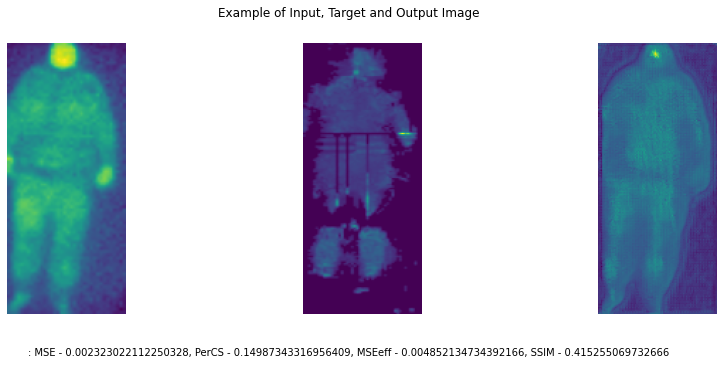

In [21]:
total_metric = [0, 0, 0, 0]

model.eval()
torch.cuda.empty_cache()  # Clean CUDA Cache if used GPU
gc.collect()  # Collect trash to free memory not used

with torch.no_grad():
        best_input_img = None
        best_target_img = None
        best_output_img = None
        best_mse = np.inf

        for batch_idx, (input_images, target_images) in enumerate(test_loader, 1):
    
                input_img = input_images.to(DEVICE)
                target_img = target_images.to(DEVICE)
    
                output_img = model(input_img)
    
                for i, metric in enumerate(metrics):
    
                    test_metric = metric(output_img, target_img)
    
                    total_metric[i] += test_metric

                    if i == 0:
                        if best_mse > test_metric:
                            best_input_img = input_img
                            best_target_img = target_img
                            best_output_img = output_img
                            best_mse = test_metric
    
                # Free memory in each iteration
                torch.cuda.empty_cache()  # Clean CUDA Cache if used GPU
                gc.collect()  # Collect trash to free memory not used
            
print('Evaluation completed')
epoch_metric = [(total_metric[0] /
                    len(test_loader)).item(), total_metric[1] / len(test_loader),
                    total_metric[2] / len(test_loader),total_metric[3] / len(test_loader)]
    
print(metrics)
print(epoch_metric)
    
m_str = [f"MSE - {epoch_metric[0]}", f"PerCS - {epoch_metric[1]}", f"MSEeff - {epoch_metric[2]}", f"SSIM - {epoch_metric[3]}"]
    
m_str = ", ".join(m_str)
    
print(m_str)

input_images = best_input_img.squeeze().cpu().numpy()
target_images = best_target_img.squeeze().cpu().numpy()
output_img = best_output_img.squeeze().cpu().numpy()
    
#kk = max(np.max(target_images),np.max(output_img))

#target_images[0,0] = kk
#output_img[0,0] = kk
        #for i, img, title in zip(range(3), [input_images, target_images, output_img], ['Input', 'Target', 'Output']):
        #    fig, ax = plt.subplots(figsize=(5, 5))
        #    ax.imshow(img)
        #    ax.axis('off')
        #    plt.savefig(os.path.join(IMG_PATH, f"Final_Comparing_output_model-{cover}-{title}.png"))
        #    plt.close()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
axes[0].imshow(input_images)
axes[0].axis('off')
    
axes[1].imshow(target_images)
axes[1].axis('off')
    
axes[2].imshow(output_img)
axes[2].axis('off')
    
fig.suptitle(f'Example of Input, Target and Output Image', fontsize=12)
fig.text(0.5, 0.01, f': {m_str}', ha='center')
        #if save:
        #    plt.savefig(os.path.join(IMG_PATH,f"Comparing_output_model-{cover}.png"))
plt.show()